In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import copy

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

import tqdm

from scipy.stats import norm
from sklearn.cluster import AffinityPropagation

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [3]:
from AFL.automation import prepare
from AFL.automation.APIServer import DummyDriver
from AFL.automation.instrument import VirtualSANS_data
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions, GaussianProcess
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.automation.APIServer.Client import Client

In [4]:
from SAS_model_fit_driver import SAS_model_fit, sas_wrapper
import sasmodels

## Server instantiation

In [227]:
netcdf_path = '/Users/drs18/Documents/multimodal-dev/phasemap_P188_2D_MultiModal_UCB_noThomp_FixedP188_30524b88-00f7-4606-9c4d-57ad7880f95e.nc'
model_ds = xr.load_dataset(netcdf_path)

sasfit_url = 'localhost:5058'
sasfit_client = Client(sasfit_url.split(':')[0],port=sasfit_url.split(':')[1])
sasfit_client.login('SampleServer_SASfit_Client')
sasfit_client.debug(False)
sasfit_client.set_config(
    filepath='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    save_path='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    q_range = (model_ds.q.min().values.tolist(), model_ds.q.max().values.tolist()),
    model_inputs = [{
        'name':'power_law_1',
        'sasmodel':'power_law',
        'fit_params':{
            'power':{
                'value':4,
                'bounds':(3,4.5)
            },
            'background':{
                'value':1e-4,
                'bounds':(1e-10,1e2)
            },
            'scale':{
                'value':1e0,
                'bounds':(1e-6,1e4)
            }
        }
    }]
)


sasfit_client.set_driver_object(dataset=model_ds)
sasfit_client.set_driver_object(clustered=True)

<Response [200]>

## test startup and base functions

In [150]:
sasfit_client.enqueue(task_name='construct_models')

UUID('1a3c9f3f-8c36-41a3-be3e-507d1b987211')

In [238]:
config = sasfit_client.get_config('all',interactive=True)

In [239]:
dummy_model = config['return_val']['model_inputs'][0]
add_model = dummy_model
# print(add_model)
add_model['name'] = 'power_law_2'
add_model['fit_params']['power'] = {'value':2, 'bounds':[1,3]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])

add_model['name'] = 'power_law_3'
add_model['fit_params']['power'] = {'value':800, 'bounds':[100,1000]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])


UUID('f14a9410-9839-4865-b566-1ba0316da4fd')

In [240]:
sasfit_client.enqueue(task_name='remove_model',name='power_law_3')

UUID('9473a90e-6b59-4595-a4e2-459e00e35672')

## Test on real data with fitting

In [228]:
data = []
for idx in range(len(model_ds.SAS)):
    
    q = model_ds.q.values#[:-25]
    I = model_ds.SAS[idx].values#[:-25]
    dI = 0.1 * I
    data.append(np.vstack([q,I,dI]).T.tolist())
# data = sasmodels.data.Data1D(x=q,y=I,dy=dI) 
initial_models = [
    {'name':"polymer_micelle_1",
     'sasmodel':'polymer_micelle',
     'fit_params':{
            "scale"       : {'value':2*max(I), 'bounds':(1e-1,1e4)},
            "background"  : {'value':50,       'bounds':(1e-1,1e4)},
            "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            "sld_core"    : {'value':5.45,     'bounds':None},
            "sld_corona"  : {'value':5.15,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
     }
    },
    {'name':"small_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
            "scale"       : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':20,       'bounds':(1e1,1e2)},
            "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
            "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
            "radius_pd_type": {'value':'gaussian','bounds':None},
            "radius_pd_n": {'value':15,'bounds':None},
            "sld"         : {'value':5.45,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
        }
    },
    {'name':"poly_gauss_coil_1",
     'sasmodel':'poly_gauss_coil',
     'fit_params':{
            "i_zero"      : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            # "polydispersity": {'value':1,       'bounds':(0.5,2)}
        }
    }
]

In [229]:
sasfit_client.set_config(model_inputs=initial_models)

UUID('43602b5c-3a89-4665-aa1e-67f9eb7ba842')

In [230]:
sasfit_client.enqueue(task_name='construct_models')

UUID('19e50723-854b-4a08-b337-74fdda6f9a76')

In [231]:
sasfit_client.enqueue(task_name='print_model_pointer')

UUID('fdcf6d75-9d42-4ebe-8b5e-af9bd2949af8')

### batch fitting

In [232]:
fit_method={'method':'lm',
            'steps':1000,
            'ftol': 1.5e-6,
            'xtol': 1.5e-6,
            'verbose':True
           }
data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
sasfit_client.enqueue(task_name="fit_models",data=data,
                      data_ID=data_ID,
                     fit_method=fit_method)

UUID('b9fcc591-f018-4b5b-97a4-b05561b1cc80')

In [233]:
sasfit_client.enqueue(task_name='build_report',verbose=False)
report_json = sasfit_client.get_driver_object('report')
report_json['best_fits']

{'model_name': [0.10901291008439683,
  0.3600402351279607,
  2.2147566763164708,
  0.1011933177509012,
  0.09637957298044064,
  0.0985966273724926,
  0.04540412675729783,
  0.09378359565381142,
  0.2618096522631371,
  0.07332627609985672,
  0.14911322985481246,
  0.1278234724748884,
  0.30313897214214336,
  0.0760128057896071,
  0.0689023966343068,
  0.09769008742055015,
  0.09725923721099293,
  0.05412722736718673,
  0.06200199995503472,
  0.04465750679127732,
  0.08015696487689328,
  0.188836584154557,
  0.11384911231497433,
  0.11083527023442226,
  0.1487101261901348,
  0.10736126394304668,
  0.15710737811115977,
  0.09284817649402902,
  0.048305295414980375,
  0.058094286843716654,
  0.08637762999923543,
  0.17109480406596422,
  0.15698437113696798],
 'lowest_chisq': ['polymer_micelle_1',
  'small_sphere_1',
  'polymer_micelle_1',
  'poly_gauss_coil_1',
  'poly_gauss_coil_1',
  'poly_gauss_coil_1',
  'poly_gauss_coil_1',
  'poly_gauss_coil_1',
  'small_sphere_1',
  'polymer_micelle

## Report pull and reconstituting

Human readable analysis and reporting


scale 1294.2873864290034
background 35.609734492608546
radius_core 37.48025156993604
rg 18.66600189120689
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 13.935168197223192
background 41.95270571381679
radius 31.505332594639274
radius_pd 0.4999559652654644
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1297.626378712315
background 33.1288460640549
rg 121.11568640319045


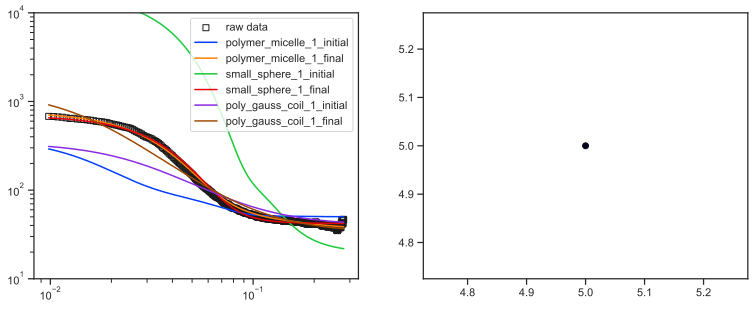


scale 9999.451493252198
background 23.96022799851097
radius_core 54.723717202815436
rg 122.16716131959609
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 23.113937238722137
background 24.890058111095918
radius 46.24236150819334
radius_pd 0.3042487471428816
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.07910365809
background 18.142614711373913
rg 369.38517208835714


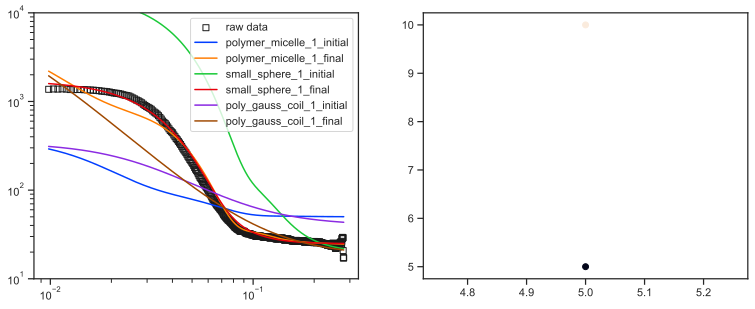


scale 9999.781534681144
background 33.949515463296336
radius_core 109.92961365994356
rg 127.52909383895152
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 3.2048398226288186
background 35.792146820417805
radius 55.43283205826872
radius_pd 0.49996185145556854
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9995.806575552871
background 32.37918472750514
rg 673.3132925153192


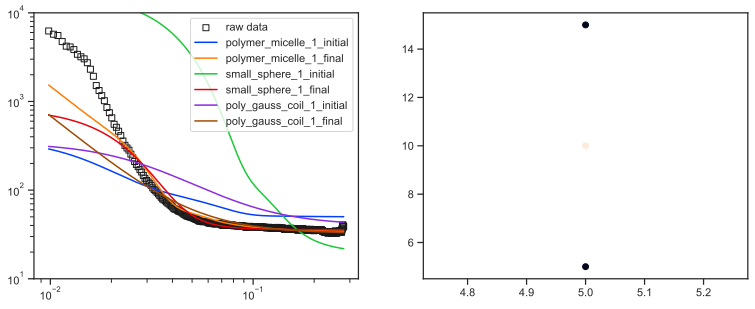


scale 486.2372880374095
background 55.60807996275612
radius_core 25.733132999416558
rg 133.1890239277209
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.565213635186138
background 55.51964961391487
radius 16.23818863939021
radius_pd 0.499981093218451
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.83814773081053
background 51.08538158938465
rg 34.27103135891968


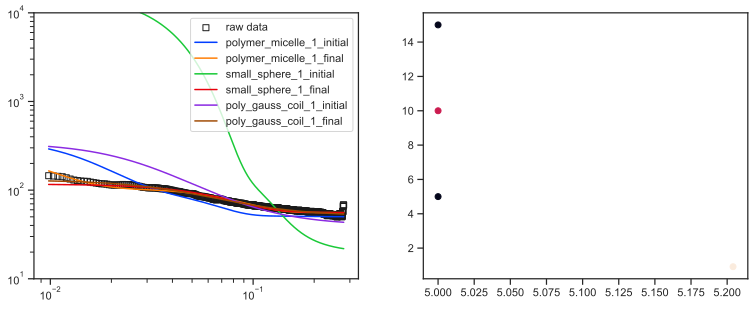


scale 535.3141572082789
background 54.51153445955247
radius_core 25.37753055412366
rg 140.7388415347286
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 11.13900016762528
background 54.359109909726776
radius 15.856270753850218
radius_pd 0.49997266510071037
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 85.34415859933645
background 49.40108315698792
rg 33.249979384667306


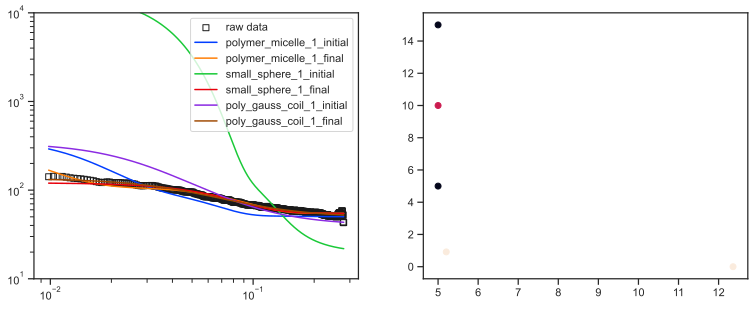


scale 124.86675713122877
background 51.019606129715974
radius_core 10.623255100894772
rg 16.296912926135114
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.758665921631493
background 55.15821899009965
radius 15.585153104900117
radius_pd 0.49998541599332236
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 69.93295808400393
background 50.70375653103169
rg 31.682223503220353


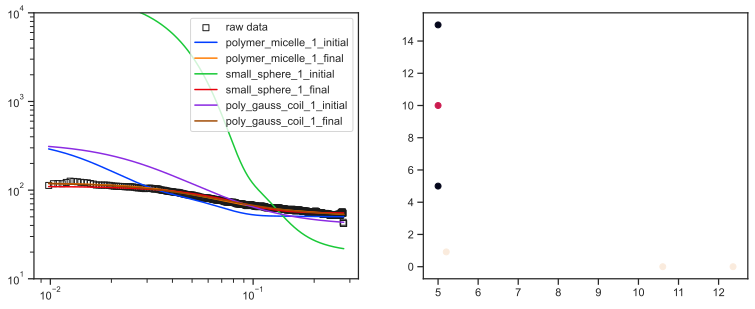


scale 499.0230659753154
background 55.32524184675852
radius_core 25.30451171320417
rg 143.8977519316623
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 10.559144257574431
background 55.15689175149108
radius 15.718048981275574
radius_pd 0.4999660914889603
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.29217902230025
background 50.44474201986924
rg 32.589760925425814


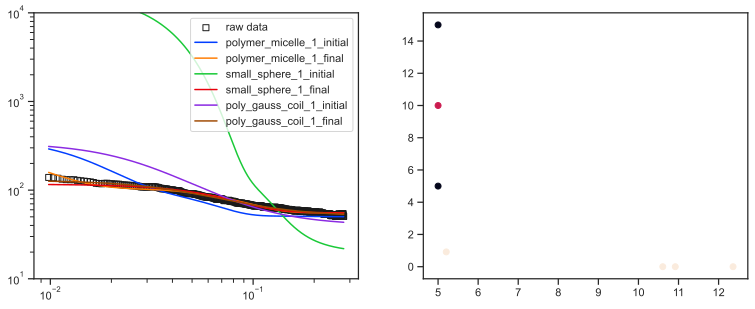


scale 449.21993375545424
background 55.44476421403142
radius_core 25.35842459340548
rg 125.47050083247639
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 8.745509036405938
background 55.50683475621905
radius 16.478767672208658
radius_pd 0.4999536003946283
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.97943441885913
background 51.39512775351118
rg 35.20459533211085


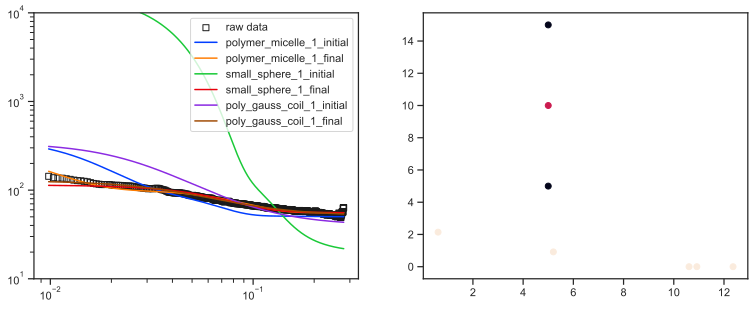


scale 9999.177866196862
background 26.221294453641903
radius_core 57.78289522189193
rg 107.50055139447932
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 20.643645352707345
background 27.71172213044125
radius 50.13071787667638
radius_pd 0.28194014107883847
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.28143389266
background 21.815530360212016
rg 400.14933715999456


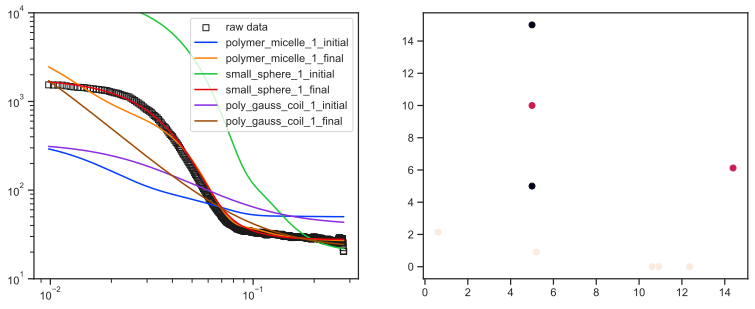


scale 1133.5313733663033
background 40.36052772892975
radius_core 37.57566170082522
rg 18.45946879116203
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 12.045365569968045
background 46.12542782733645
radius 31.69619292164533
radius_pd 0.49995126759349223
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1091.0371339161682
background 37.645401949939455
rg 115.34595436885445


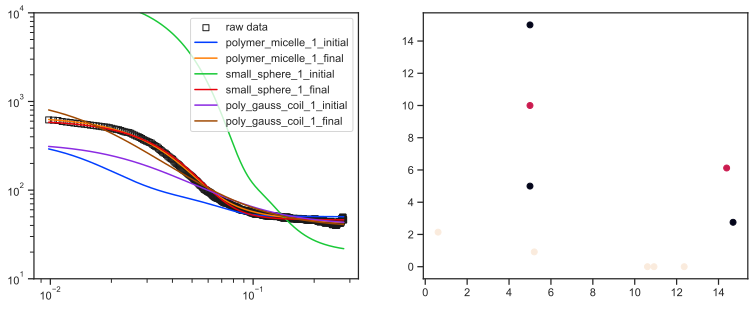


scale 550.4696111340548
background 52.895254736326045
radius_core 24.486340226927144
rg 135.10400521846876
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 12.72411110945443
background 52.7400675571811
radius 15.340452958920281
radius_pd 0.4999691794225301
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 88.42973711575199
background 47.36488436161729
rg 31.914121149010143


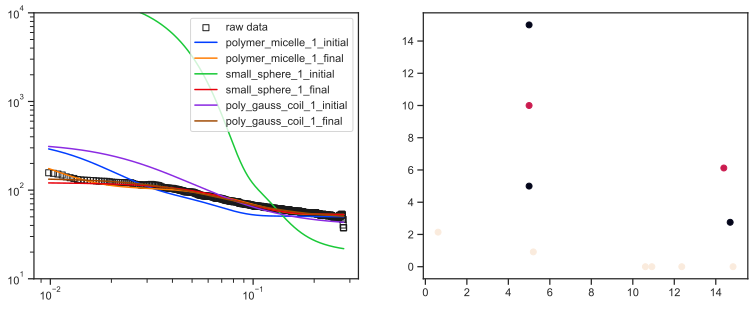


scale 571.7343421004301
background 52.16428270980382
radius_core 29.18702363579042
rg 24.28506743897882
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.464514305538129
background 54.88602387133804
radius 28.95155511294794
radius_pd 0.49995135756119713
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 423.6861455840055
background 48.27526521152825
rg 82.10960345405486


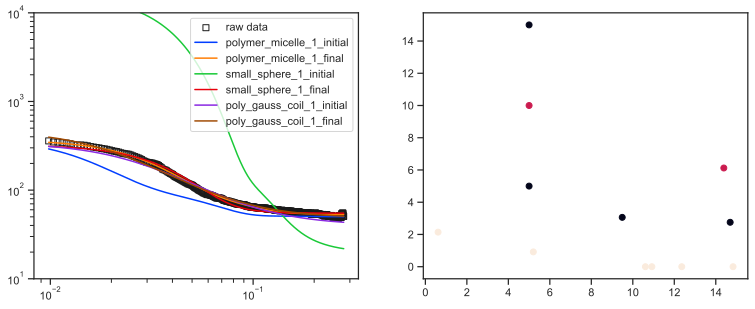


scale 1686.6802396967294
background 30.48903795980531
radius_core 38.96196746976211
rg 19.21987053935638
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 16.86968723968748
background 38.322350144843604
radius 32.65605807649624
radius_pd 0.49995666817725193
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1987.412855767648
background 29.157825234456237
rg 145.30763762422816


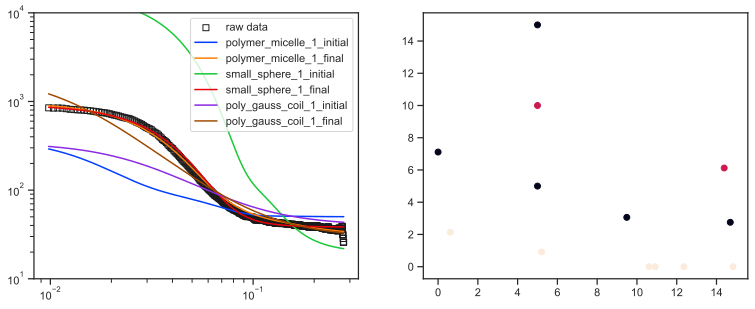


scale 491.1069862328927
background 55.80137535345579
radius_core 25.967764899700775
rg 141.86974036851458
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.432828540920749
background 55.69471521692889
radius 16.30140437301218
radius_pd 0.49997689770153153
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.79673156839712
background 51.347882968784255
rg 34.63552963810995


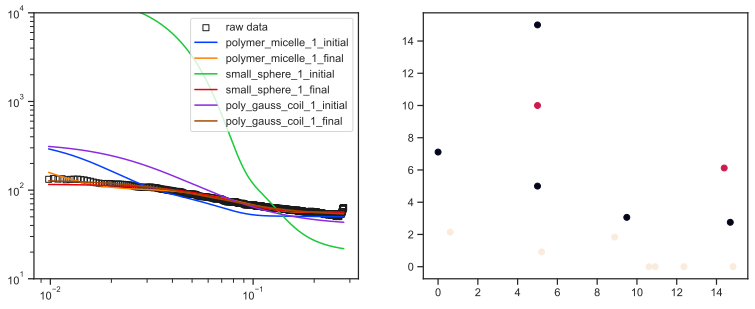


scale 138.49299426820835
background 52.18746849633749
radius_core 11.69441976727896
rg 17.099969818839472
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.421892654497672
background 56.07124327905803
radius 16.35992200282135
radius_pd 0.4999562404358789
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.98890932070087
background 51.59367365518052
rg 34.315656139328226


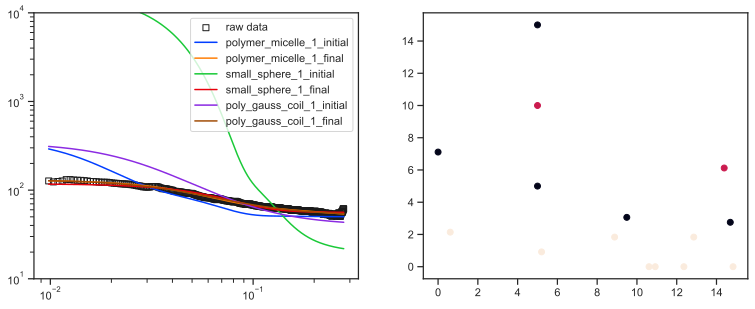


scale 295.9359048757605
background 53.07912375263137
radius_core 19.07575643727015
rg 25.81625654134882
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 5.901092303241424
background 56.6667721925069
radius 25.101861763287598
radius_pd 0.4999639550143382
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 191.55637082968852
background 51.52135875987737
rg 60.49373491914148


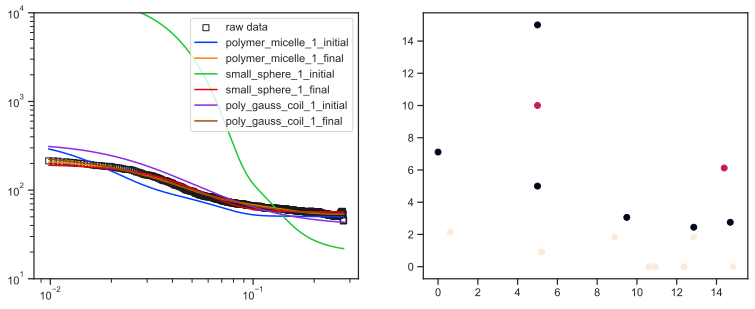


scale 136.74068190737486
background 52.389920471477296
radius_core 10.913977644030254
rg 17.454485619440906
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.582512158206045
background 56.76230392953166
radius 16.048109451080684
radius_pd 0.4999742706477276
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.96925862485149
background 52.31817226503132
rg 33.48051575317128


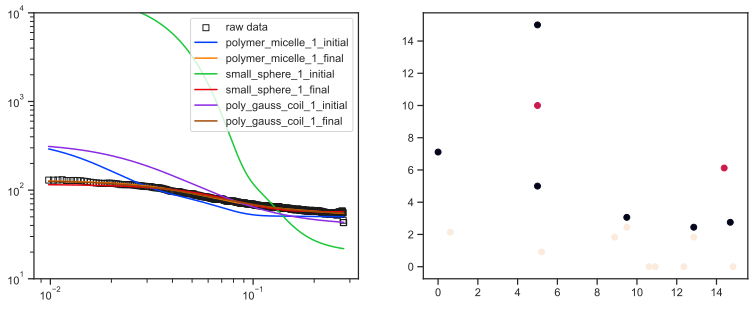


scale 175.5301285580855
background 51.873294509361585
radius_core 13.236439534664402
rg 21.796442602937564
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.248908898004454
background 56.08376397781891
radius 19.069188844275004
radius_pd 0.49996059823021016
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 98.84252169187556
background 51.757145151499465
rg 42.13862617334203


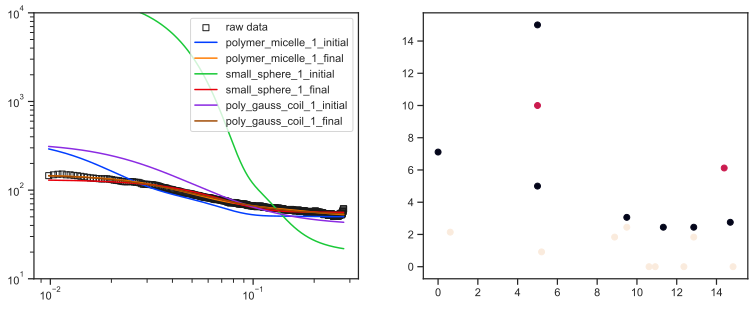


scale 468.5390979613536
background 55.401211538059314
radius_core 25.566655871088848
rg 143.66753371412022
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.39046310367492
background 55.30729794945092
radius 16.063013594072427
radius_pd 0.49995454537839296
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 74.59349546150072
background 50.94875497031189
rg 33.50569702057249


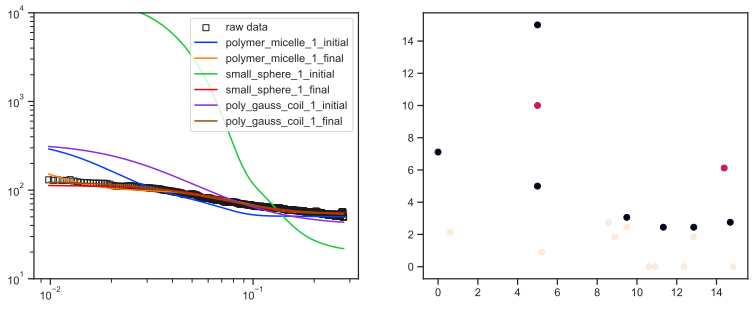


scale 238.04400022888723
background 53.40739411715919
radius_core 16.192793235308823
rg 23.76821387905502
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.098540086734315
background 57.11820265536867
radius 21.44134422542888
radius_pd 0.49996287935881045
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 141.07976394165132
background 52.179843302201014
rg 49.56329500298415


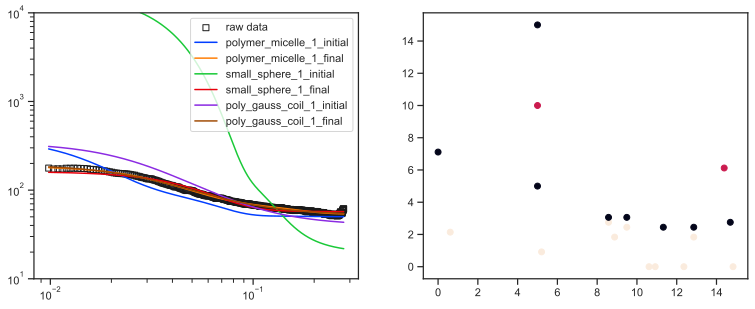


scale 923.1509466332875
background 45.28369447987295
radius_core 36.83503190614386
rg 18.248066098642305
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 10.175550600931727
background 50.08171600502063
radius 31.25211750547185
radius_pd 0.49995328732109684
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 800.6929703456015
background 42.04039659118324
rg 102.47698974016532


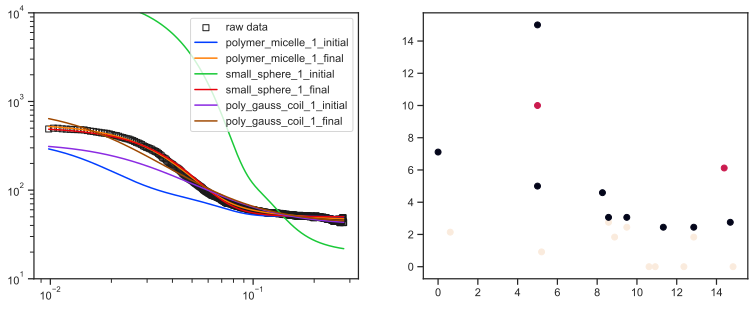


scale 1315.8398742955444
background 37.26626916155101
radius_core 38.50040900840593
rg 17.49141993780827
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 13.851206249491584
background 44.35106707977594
radius 31.859231360374235
radius_pd 0.4999636175905792
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1295.8028672583116
background 35.2509140714052
rg 119.58427363541479


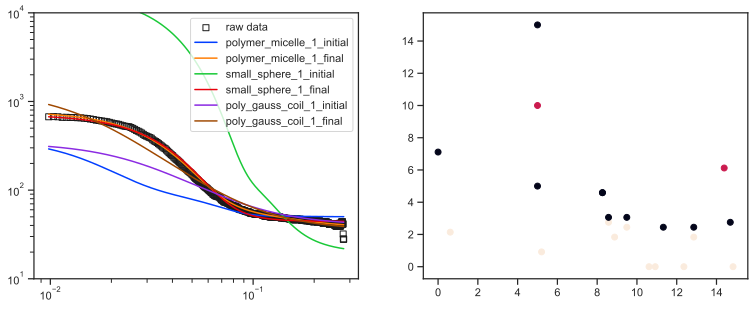


scale 470.73439277114534
background 57.260572526688044
radius_core 25.7319887746956
rg 141.578570832198
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.219622757209311
background 57.180007557034614
radius 16.205219481921993
radius_pd 0.4999786258339801
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.58402514182285
background 52.920245711039854
rg 34.22933181361541


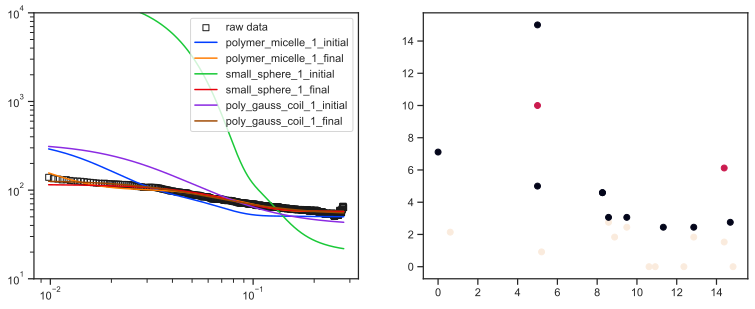


scale 443.39466394498737
background 51.26168070195261
radius_core 25.110011508580232
rg 25.023908641955103
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.99146079412585
background 54.023882280116595
radius 27.110723285855205
radius_pd 0.4999872213386664
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 306.30561229768665
background 47.964408221575916
rg 71.58698080148221


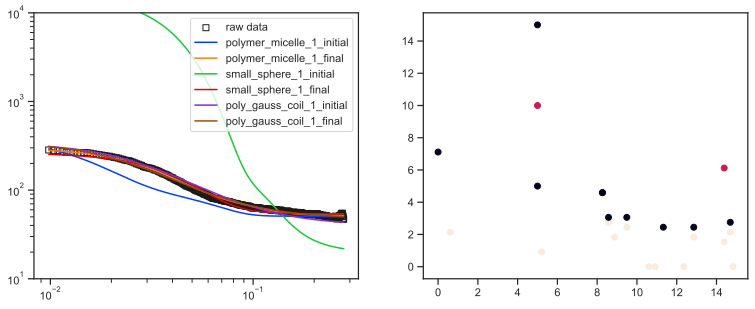


scale 614.8507042471575
background 48.279246864620475
radius_core 30.748526254379847
rg 22.71925541515432
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.896436188756051
background 51.07965529597122
radius 29.27300781876998
radius_pd 0.49995172525100195
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 468.3060278592771
background 44.319597109978226
rg 85.13698612064017


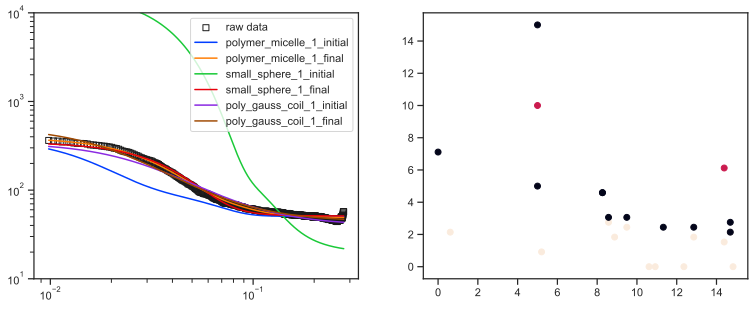


scale 361.7996825118573
background 51.25629027746893
radius_core 21.591775007068662
rg 26.221715626781716
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.4088224092143
background 54.45214215612668
radius 25.990077568523375
radius_pd 0.49998490368454834
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 243.8468487842114
background 48.96154389325056
rg 66.38104138341994


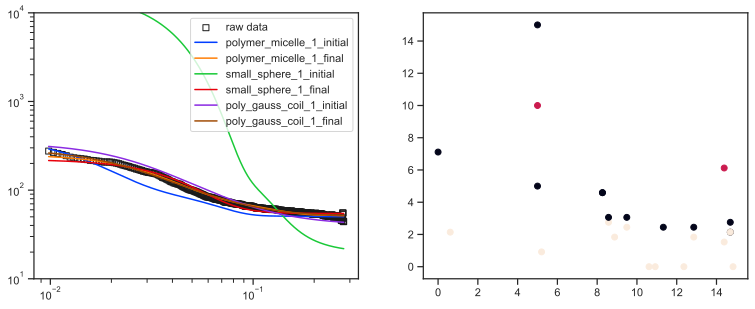


scale 478.30336032758646
background 51.80982051923285
radius_core 26.753336940810165
rg 24.340264484814256
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.123715722924125
background 54.450839473593625
radius 27.68822818823948
radius_pd 0.4999599763678131
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 337.5510700726999
background 48.22602587881865
rg 74.62479815707347


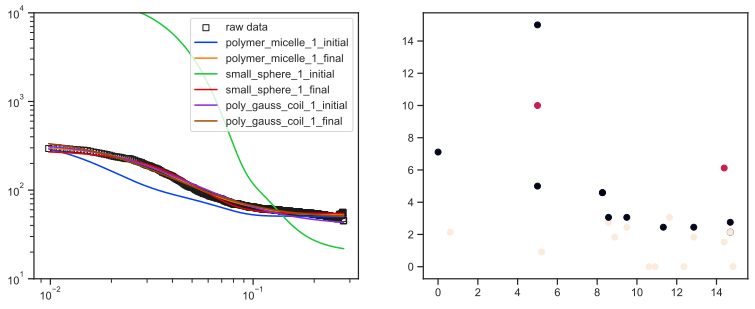


scale 411.33846822386687
background 51.60381638852299
radius_core 24.188808050060484
rg 25.63758481061395
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.618527019441947
background 54.39772862966853
radius 26.849124758798318
radius_pd 0.49998469881227936
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 282.14738122816556
background 48.63847147417881
rg 70.44968811948476


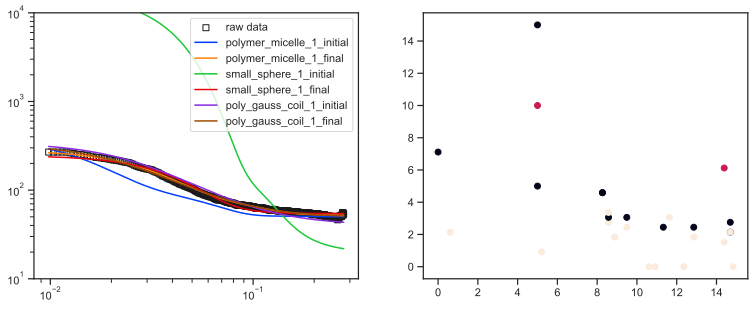


scale 209.53090608764768
background 49.958774193801496
radius_core 15.138193638715212
rg 25.40294548553303
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 5.499996184037141
background 54.14144880805601
radius 22.40045804679638
radius_pd 0.49998971983415563
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 124.93112269369918
background 49.9432720311593
rg 51.85533658911706


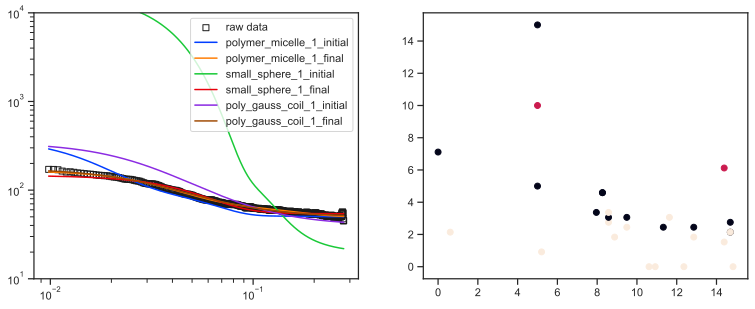


scale 286.8590084411729
background 50.973268947904735
radius_core 18.57288641012881
rg 24.798869372608277
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.745635095455541
background 54.34446254551958
radius 23.448852330529327
radius_pd 0.499960183694819
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 180.40602263524363
background 49.17244777144523
rg 56.66179700766375


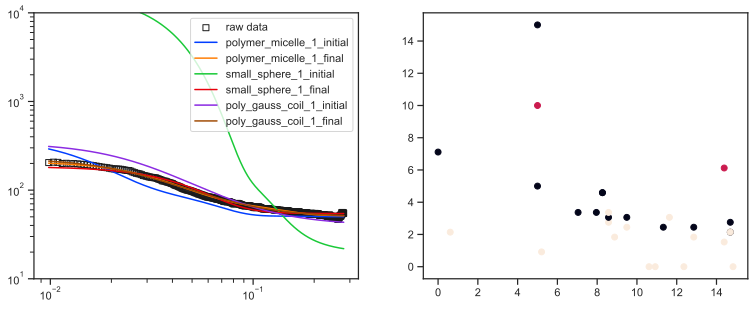


scale 132.09787648156214
background 50.70948359874753
radius_core 11.085796025273414
rg 17.931497806694065
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.133348588220635
background 54.73348735395916
radius 16.029720566951106
radius_pd 0.49997911015583746
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 72.2466373337999
background 50.485605781676746
rg 33.395754433447735


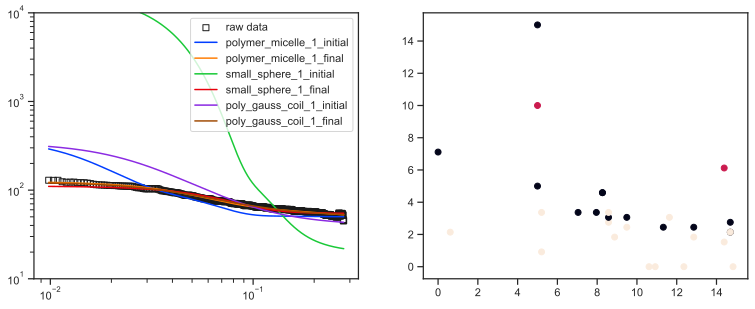


scale 271.22694874489827
background 52.1214125006806
radius_core 16.733838954674855
rg 25.909799589002176
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.149145612973543
background 56.50438594100918
radius 23.826207106088496
radius_pd 0.49995903099169714
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 172.66542620014033
background 51.55047276518568
rg 57.28117865045105


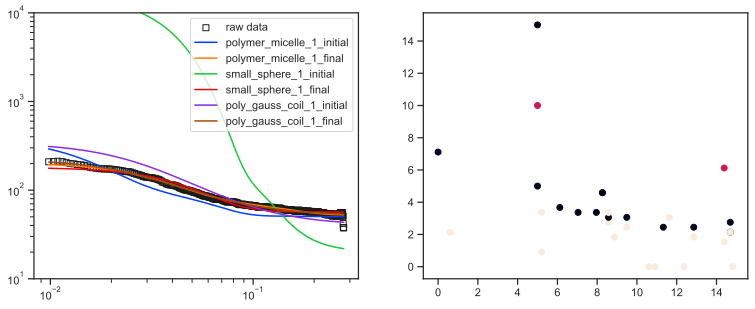


scale 478.78716033904044
background 51.19169587477239
radius_core 24.63706564648923
rg 24.60378620106165
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.985885359980943
background 54.202645010302035
radius 26.595930276274494
radius_pd 0.49996789189857016
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 331.8701251854695
background 47.61802088338626
rg 70.48720701716856


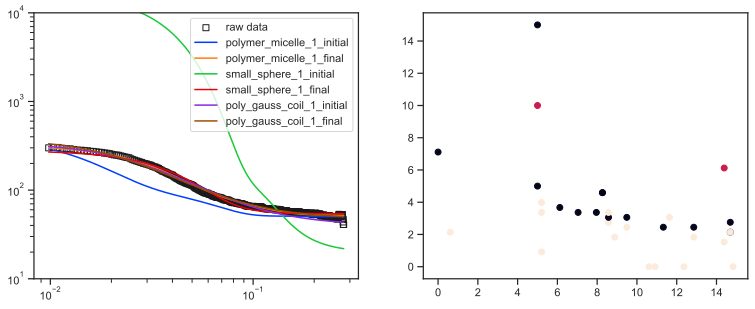

In [188]:
def label_items(arr):
    return np.unique(arr, return_inverse=True)
def label_key(arr):
    return np.unique(arr)

best_fits = []
chisqs = []
X = []
for idx in range(33):
    
    fit_method={'method':'lm',
                'steps':10000,
                'ftol': 1.5e-6,
                'xtol': 1.5e-6,
                'verbose':True
               }
    
    
    # data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
    # sasfit_client.enqueue(task_name="fit_models",data=[data[idx]],
    #                       data_ID=['data_1'],
    #                      fit_method=fit_method)
    
    
    # sasfit_client.enqueue(task_name='build_report')
    # report_json = sasfit_client.get_driver_object('report')
    
    fit_method= report_json['fit_method']
    print()
    model_starts = report_json['model_inputs']
    fit_results = report_json['model_fits'][idx]
    empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                         np.log10(model_ds.q.values.max()),
                                                         1000
                                                        ))
    # bf = report_json['best_fits'][f'data_{str(idx+1).zfill(3)}']
    # best_fits.append(bf['model_name'])
    # chisqs.append(bf['lowest_chisq'])
    best_fits.append(report_json['best_fits'][idx])
    X.append([model_ds.benzyl_alcohol_solute.values[idx],model_ds.phenol_solute.values[idx]])
    
    
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data',color='k',marker='s',facecolors='none')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = fit_results[mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model['output_fit_params']):
            print(key, fit_model['output_fit_params'][key]['value'])
            params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model['name'],
            sasmodel_type=fit_model['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log',
            ylim= (1e1,1e4)
        )
        ax[0].legend()
    _, clss = label_items(best_fits)
    key = label_key(best_fits)
    ax[1].scatter(np.array(X)[:,0],np.array(X)[:,1],c=clss)
    plt.show(fig)
    plt.close(fig)

In [167]:
label_items(best_fits)

(array(['polymer_micelle_1'], dtype='<U17'), array([0]))

## Serial Fitting

In [ ]:
sasfit_client.enqueue(task_name='build_report')
report_json = sasfit_client.get_driver_object('report')
report_json
fit_method= report_json['fit_method']
model_starts = report_json['model_inputs']
fit_results = report_json['model_fits']
empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                     np.log10(model_ds.q.values.max()),
                                                     1000
                                                    ))
for idx in range(len(model_ds.SAS.values)):
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = fit_results[mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model[mdx]['output_fit_params']):
            params_final[key] = {'value':fit_model[mdx]['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model[mdx]['name'],
            sasmodel_type=fit_model[mdx]['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log'
        )
        ax[0].legend()
    plt.show(fig)
    plt.close(fig)

[0.10901291008439683, 0.4666097823923236, 1.4276706821023006] 0 polymer_micelle_1
[1.5796703532257839, 2.8008062189137344, 7.610963666871448] 0 polymer_micelle_1
[240.50111473440015, 2.6669240807387435, 4.2167754516434215] 1 small_sphere_1
[589.0080232106926, 19.82083824548737, 6.921357775311741] 2 poly_gauss_coil_1
[551.4233011171323, 12.986913851906541, 6.803085921655831] 2 poly_gauss_coil_1
[706.1922602934334, 6.028173140784286, 6.859588526077948] 1 small_sphere_1
[601.1235011580019, 3.318372031259583, 6.586875424755204] 1 small_sphere_1
[618.2655813773314, 0.991923320840426, 6.116537457279797] 1 small_sphere_1
[2.147048455788609, 12.365805119131792, 41.59374120827924] 0 polymer_micelle_1
[31.4664937425923, 3.8337061648000783, 10.477807592361469] 1 small_sphere_1
[378.5663401558229, 11.24442383777559, 6.139409342537034] 2 poly_gauss_coil_1
[83.69993058363599, 4.49672756001287, 8.846923893896859] 1 small_sphere_1
[8.701593251151465, 0.7618174531008985, 15.304630253281633] 1 small_sph

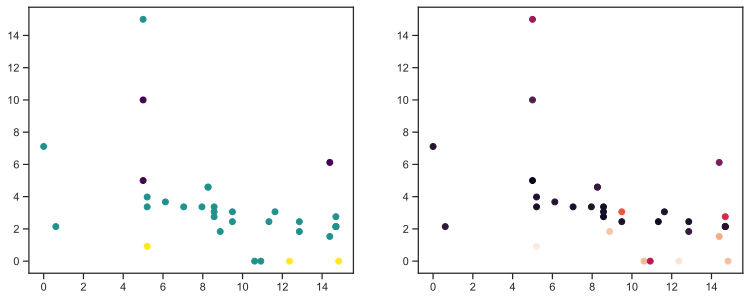

In [506]:
labels = []
ID = []
chisqr = []

for fit in sasfit_client.get_driver_object('results'):
    all_chisq = [fit[mdx]['chisq'] for mdx in range(len(fit))]
    best_idx = np.nanargmin(all_chisq)
    best_model = fit[best_idx]['name']
    print(all_chisq,best_idx,best_model)
    labels.append(best_model)
    ID.append(best_idx)
    chisqr.append(np.min(all_chisq))

x,y = model_ds.benzyl_alcohol_solute.values, model_ds.phenol_solute.values
# x,y = x[:3],y[:3]
fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
ax[0].scatter(x,y,c=ID,label=labels,cmap='viridis')
ax[1].scatter(x,y,c=chisqr)

In [507]:
test = sasfit_client.get_config('model_inputs')